# Временные ряды

![](https://mlcourse.ai/images/topic4-teaser.png)

Временно́й ряд — собранный в разные моменты времени статистический материал о значении каких-либо параметров исследуемого процесса.

Скалярным временным рядом 
$$\{x_i\}_{i=1}^N$$
называется массив из $N$ чисел, представляющих собой значения некоторой измеренной (наблюдаемой динамической переменной $x(t)$ с некоторым постоянным шагом $τ$ по времени, $$t_i = t_0 + (i − 1)τ : x_i = x(t_i), i = 1, . . . , N.$$  

Такой подход используется, когда нет возможности построить уравнения движения.  

Примеры: 
- объёмы продаж в торговых сетях
- объёмы потребления и цены электроэнергии
- остатки складских запасов
- рыночные цены
- дорожный трафик (прогнозирование пробок)

Основные свойства временных рядах:
- тренды
- сезонности

Какие задачи здесь возникают?

Для начала визуализируем наши данные и попробуем сформулировать новые гипотезы о задаче, которую хотим решить.

Загрузим данные и посмотрим на структуру данных

## Чтение данных

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv('MarketArrivals_Ind.csv')

## Прогнозирование временного ряда

In [12]:
df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by = "date")
df.index = pd.PeriodIndex(df.date, freq='M')

In [13]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


In [14]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Будем работать с данными в городе Бангалор

In [15]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [16]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


In [17]:
# Удалим лишние столбцы
dfBang = dfBang.drop(["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis = 1)

In [18]:
dfBang.shape

(146, 3)

In [19]:
dfBang.head()

,quantity,priceMod,date
date,,,
2004-01,227832,991,2004-01-01
2004-02,225133,793,2004-02-01
2004-03,221952,556,2004-03-01
2004-04,185150,465,2004-04-01
2004-05,137390,455,2004-05-01


<AxesSubplot:xlabel='date'>

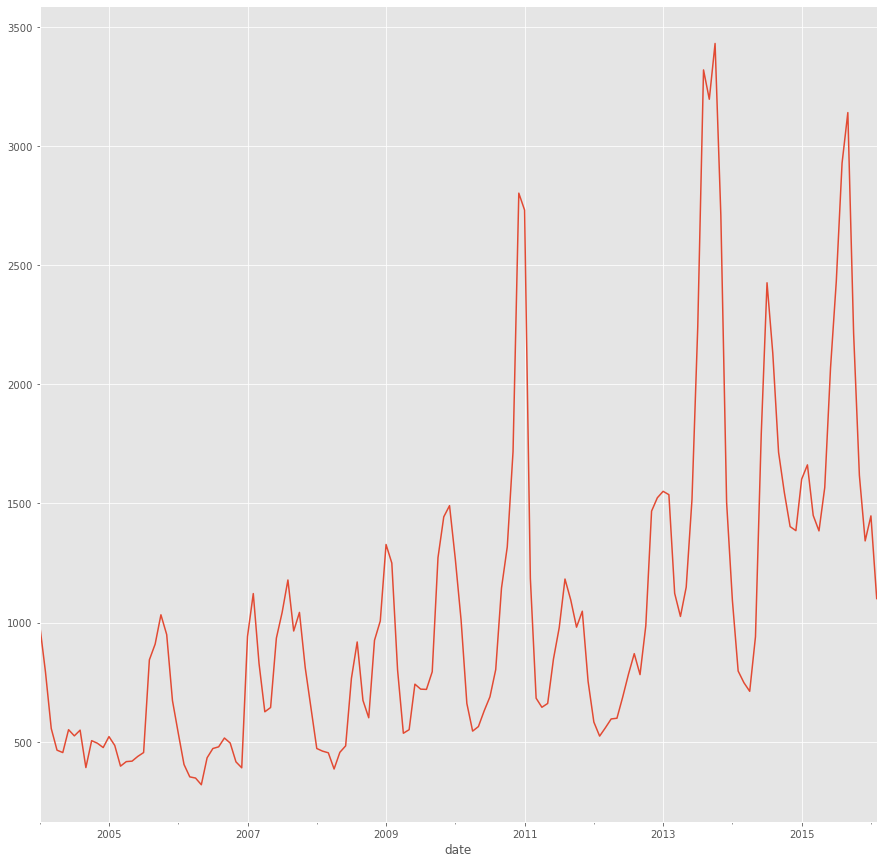

In [20]:
dfBang.priceMod.plot()

## Начнем с трех простых моделей прогноза цены

### 1. Прогнозирование средним (Mean Constant Model)
### 2. Линейная модель (Linear Trend Model)
### 3. Линейная модель с регрессий (Linear Regression Model)

### Логарифмическое преобразование данных
Логарифмирование помогает стабилизировать разброс значений.

<AxesSubplot:ylabel='Frequency'>

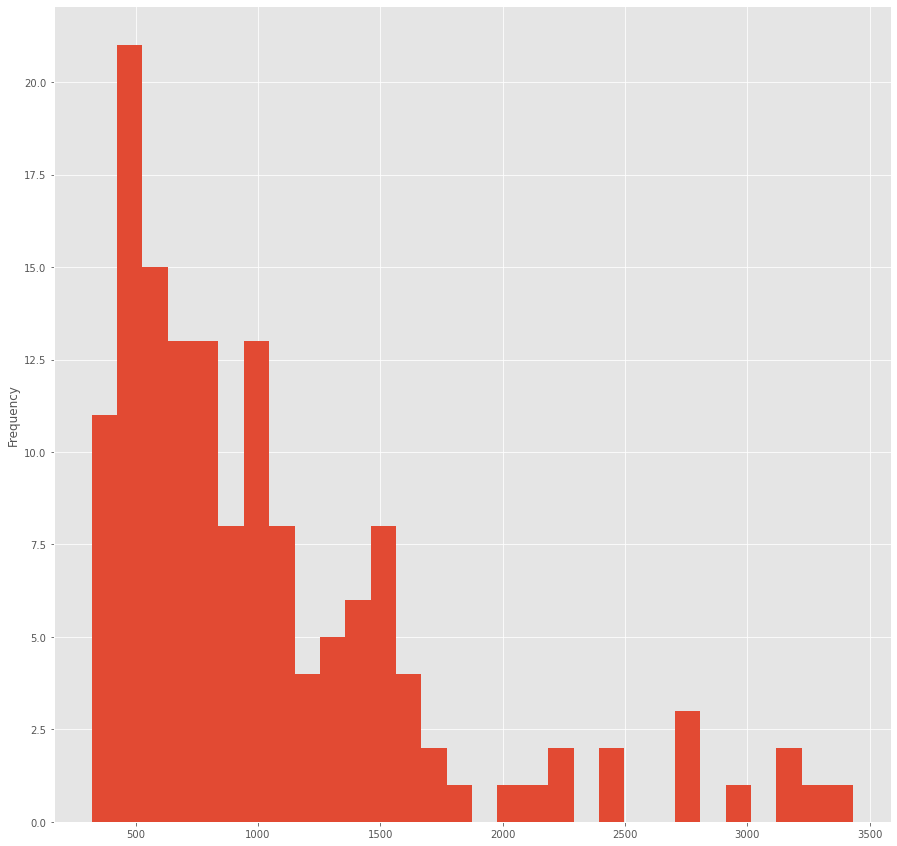

In [21]:
dfBang.priceMod.plot(kind = "hist", bins = 30)

При визуализации можем заметить, что есть данные, далеко отстающие от среднего значения, что может искажать модель регрессии. Наша задача минимизировать влияние таких данных. Желательно не исключая их.  
В этом случае самый распространенный вариант действия - логарифмирование переменной.

In [22]:
dfBang['priceModLog'] = np.log(dfBang.priceMod)
dfBang.head()

,quantity,priceMod,date,priceModLog
date,,,,
2004-01,227832,991,2004-01-01,6.90
2004-02,225133,793,2004-02-01,6.68
2004-03,221952,556,2004-03-01,6.32
2004-04,185150,465,2004-04-01,6.14
2004-05,137390,455,2004-05-01,6.12


<AxesSubplot:ylabel='Frequency'>

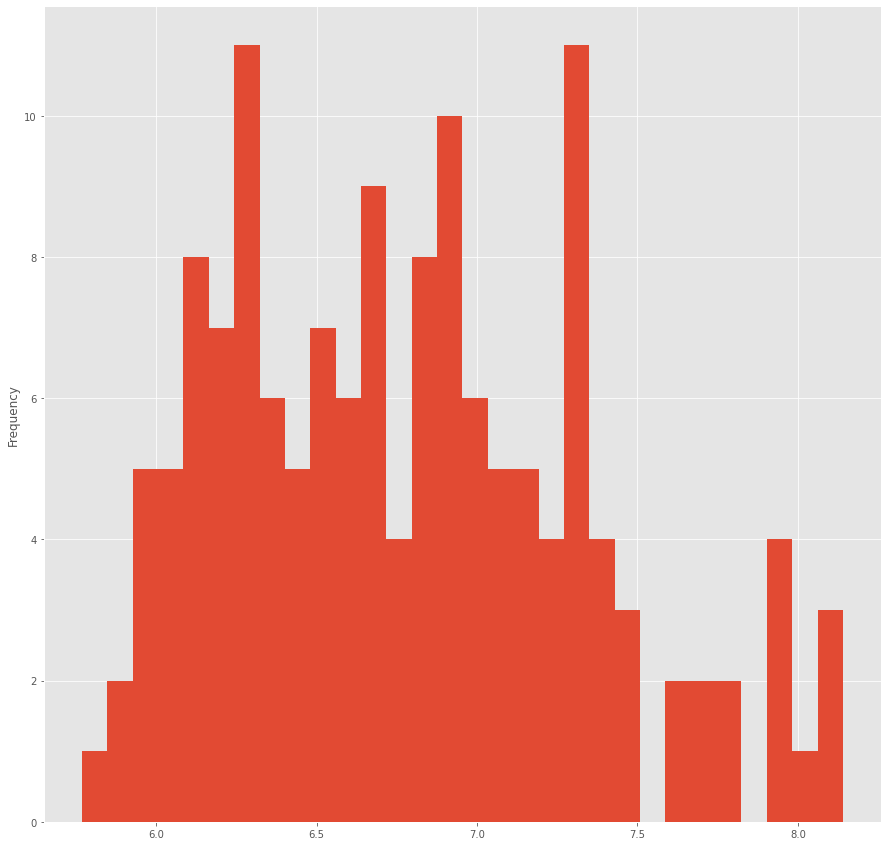

In [23]:
dfBang.priceModLog.plot(kind = "hist", bins = 30)

<AxesSubplot:xlabel='date'>

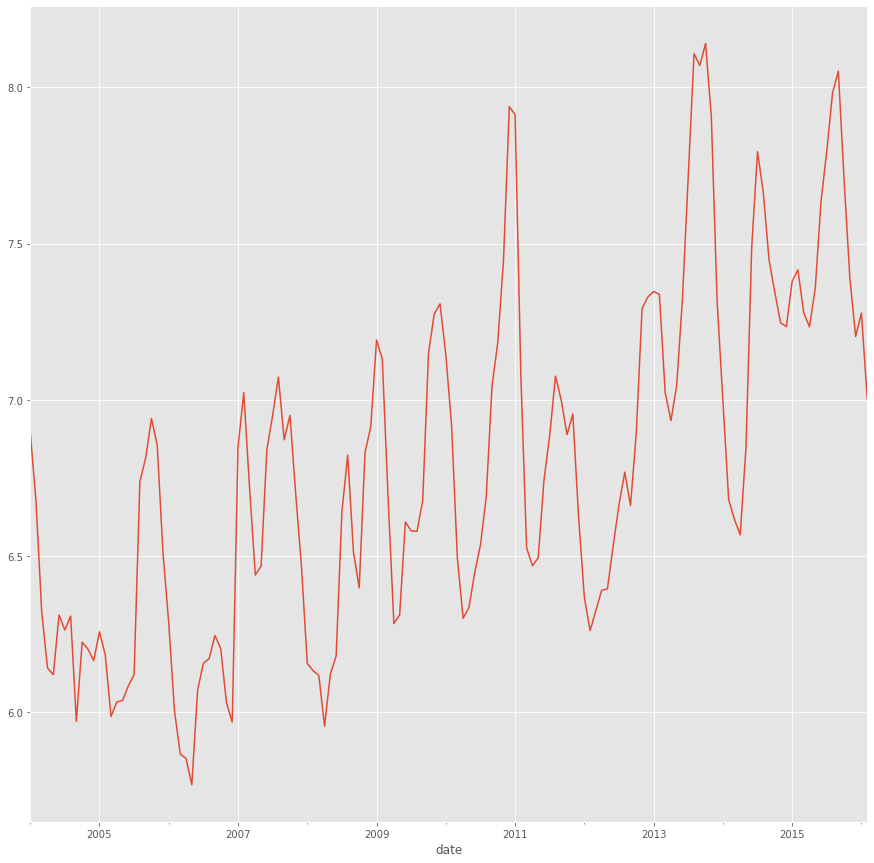

In [24]:
dfBang.priceModLog.plot()

## 1.1. Прогнозирование средним 

In [25]:
model_mean_pred = dfBang.priceModLog.mean()

In [26]:
# Запишем это значение в priceMean
dfBang["priceMean"] = np.exp(model_mean_pred)

<AxesSubplot:xlabel='date'>

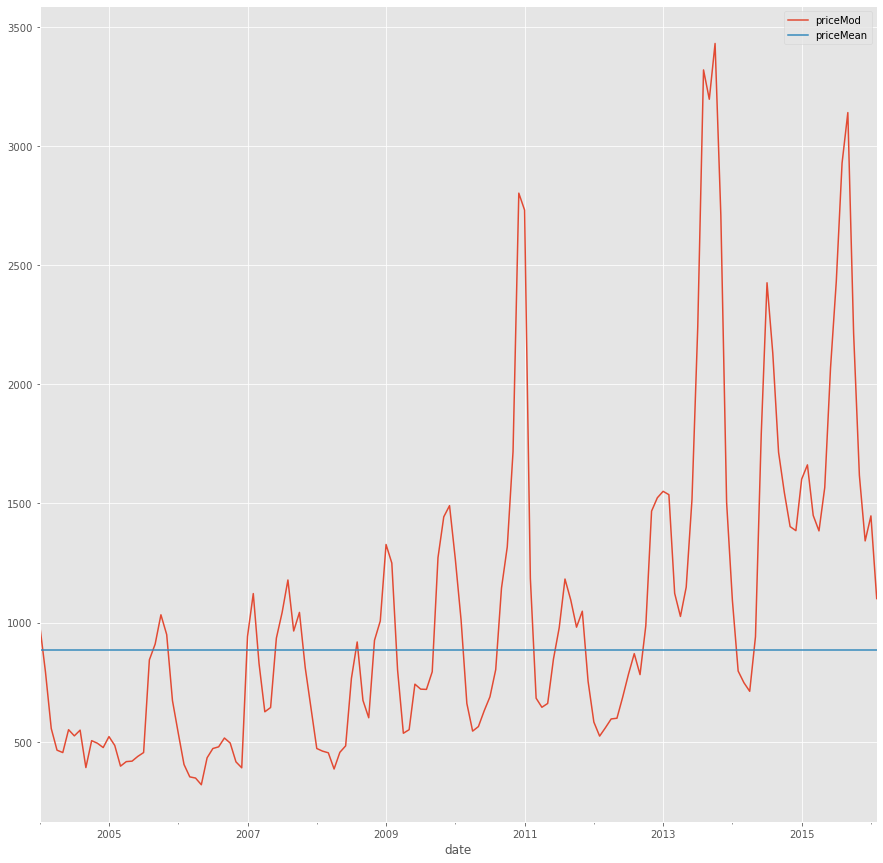

In [27]:
dfBang.plot(kind="line", x="date", y = ["priceMod", "priceMean"])

**Как мерить качество?**

Чтобы обучать регрессионные модели, нужно определиться, как именно измеряется качество предсказаний.   
Будем использовать метрику RMSE (Root Mean Squared Error) - корень среднего квадрата отклонения.

$$RMSE = \Sigma \sqrt{ (\hat{y} - y)^2/n} $$ , 
где $\hat{y}$ это предсказанное значение y

#### Какие еще метрики применимы в задачах с временными рядами?

In [28]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [29]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

683.9533483996255

In [30]:
dfBangResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfBangResults.head()

,Model,Forecast,RMSE


In [31]:
dfBangResults.loc[0,"Model"] = "Mean"
dfBangResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfBangResults.loc[0,"RMSE"] = model_mean_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.57,683.95


## 1.2. Линейная модель

Построим линейную зависиммость между priceModLog and time.   
Уравнение регрессии строится с помощью метода наимменьших квадратов.

In [32]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean
date,,,,,
2004-01,227832,991,2004-01-01,6.90,884.57
2004-02,225133,793,2004-02-01,6.68,884.57
2004-03,221952,556,2004-03-01,6.32,884.57
2004-04,185150,465,2004-04-01,6.14,884.57
2004-05,137390,455,2004-05-01,6.12,884.57


In [33]:
dfBang.dtypes

quantity                int64
priceMod                int64
date           datetime64[ns]
priceModLog           float64
priceMean             float64
dtype: object

In [34]:
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [35]:
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()

In [36]:
dfBang.dtypes

quantity                 int64
priceMod                 int64
date            datetime64[ns]
priceModLog            float64
priceMean              float64
timeIndex      timedelta64[ns]
dtype: object

In [37]:
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')

In [38]:
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)

In [39]:
dfBang.timeIndex.tail()

date
2015-10    141
2015-11    142
2015-12    143
2016-01    144
2016-02    145
Freq: M, Name: timeIndex, dtype: int64

In [40]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex
date,,,,,,
2004-01,227832,991,2004-01-01,6.90,884.57,0
2004-02,225133,793,2004-02-01,6.68,884.57,1
2004-03,221952,556,2004-03-01,6.32,884.57,2
2004-04,185150,465,2004-04-01,6.14,884.57,3
2004-05,137390,455,2004-05-01,6.12,884.57,4


In [41]:
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

In [42]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     139.8
Date:                Thu, 13 May 2021   Prob (F-statistic):           5.75e-23
Time:                        08:34:44   Log-Likelihood:                -72.317
No. Observations:                 146   AIC:                             148.6
Df Residuals:                     144   BIC:                             154.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1121      0.066     92.830      0.000       5.982       6.242
timeIndex      0.0093      0.001     11.823      0.000       0.008       0.011
==============================================================================
Omnibus:                        4.750   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.739
Skew:                           0.405   Prob(JB):                       0.0935
Kurtosis:                       2.648   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Выведем параметры нашей линейной модели

In [43]:
model_linear.params

Intercept   6.11
timeIndex   0.01
dtype: float64

In [44]:
c = model_linear.params[0]
c

6.112108132763634

In [45]:
m = model_linear.params[1]
m

0.009282603918039907

In [46]:
model_linear_pred = model_linear.predict()

In [47]:
model_linear_pred

array([6.11210813, 6.12139074, 6.13067334, 6.13995594, 6.14923855,
       6.15852115, 6.16780376, 6.17708636, 6.18636896, 6.19565157,
       6.20493417, 6.21421678, 6.22349938, 6.23278198, 6.24206459,
       6.25134719, 6.2606298 , 6.2699124 , 6.279195  , 6.28847761,
       6.29776021, 6.30704282, 6.31632542, 6.32560802, 6.33489063,
       6.34417323, 6.35345583, 6.36273844, 6.37202104, 6.38130365,
       6.39058625, 6.39986885, 6.40915146, 6.41843406, 6.42771667,
       6.43699927, 6.44628187, 6.45556448, 6.46484708, 6.47412969,
       6.48341229, 6.49269489, 6.5019775 , 6.5112601 , 6.52054271,
       6.52982531, 6.53910791, 6.54839052, 6.55767312, 6.56695572,
       6.57623833, 6.58552093, 6.59480354, 6.60408614, 6.61336874,
       6.62265135, 6.63193395, 6.64121656, 6.65049916, 6.65978176,
       6.66906437, 6.67834697, 6.68762958, 6.69691218, 6.70619478,
       6.71547739, 6.72475999, 6.7340426 , 6.7433252 , 6.7526078 ,
       6.76189041, 6.77117301, 6.78045561, 6.78973822, 6.79902

In [48]:
dfBang["priceLinear"] = np.exp(model_linear_pred)

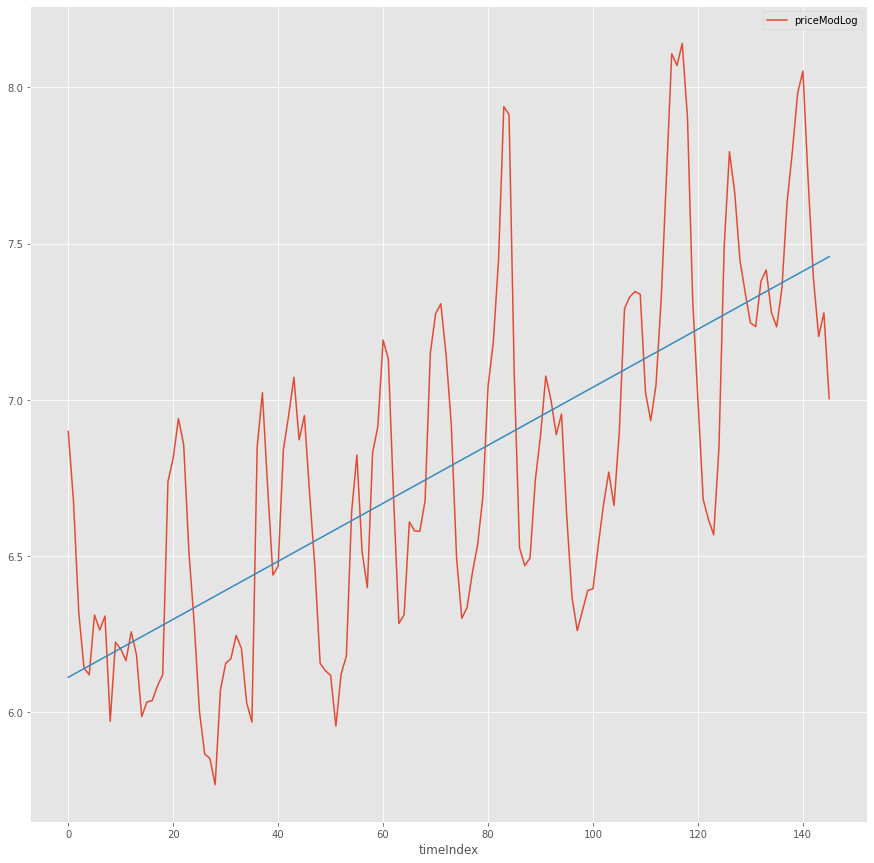

In [49]:
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfBang.timeIndex,model_linear_pred, '-')

<AxesSubplot:xlabel='date'>

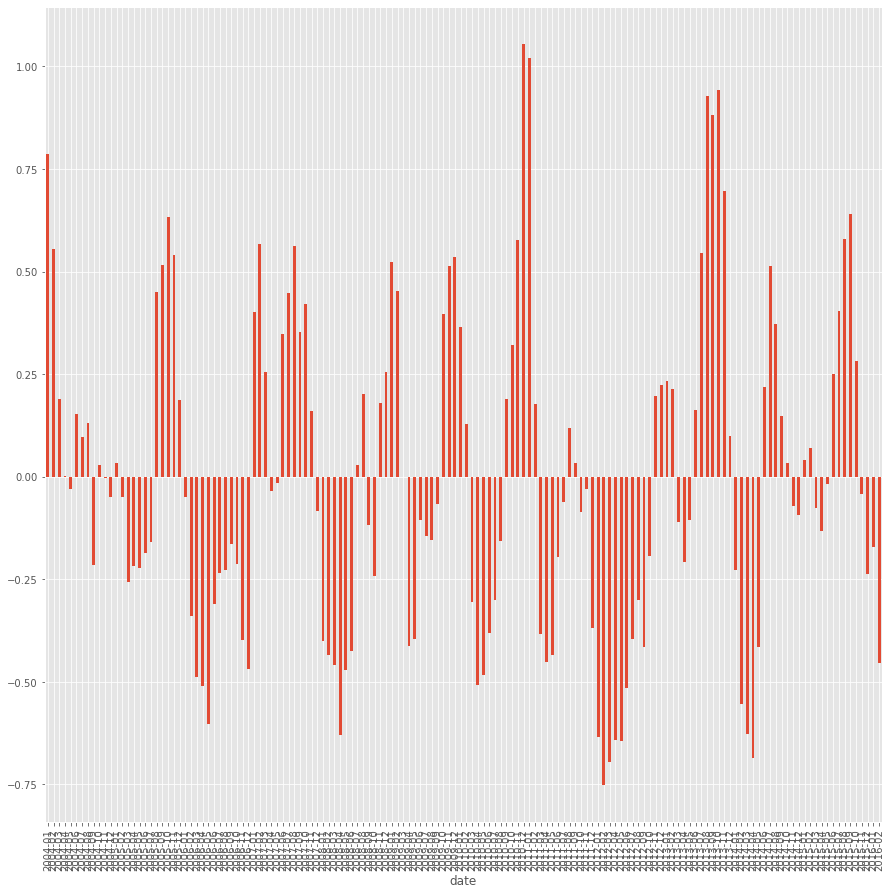

In [50]:
model_linear.resid.plot(kind = "bar")

Посчитаем ошибку RMSE на линейной модели:

In [51]:
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

518.5236075841475

In [52]:
dfBangResults.loc[1,"Model"] = "Linear"
dfBangResults.loc[1,"Forecast"] = 'Linear'
dfBangResults.loc[1,"RMSE"] = model_linear_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.57,683.95
1,Linear,Linear,518.52


## 1.3 Линейная модель с регрессией

In [53]:
## Построим регрессию, используя несколько переменных timeIndex и np.log(quantity)
model_linear_quantity = smf.ols('priceModLog ~ timeIndex + np.log(quantity)', data = dfBang).fit()

In [54]:
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     74.16
Date:                Thu, 13 May 2021   Prob (F-statistic):           8.00e-23
Time:                        08:35:56   Log-Likelihood:                -69.892
No. Observations:                 146   AIC:                             145.8
Df Residuals:                     143   BIC:                             154.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1813      0.881      4.746      0.000       2.440       5.923
timeIndex            0.0084      0.001      9.774      0.000       0.007       0.010
np.log(quantity)     0.1529      0.070      2.198      0.030       0.015       0.290
==============================================================================
Omnibus:                        5.097   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.952
Skew:                           0.403   Prob(JB):                       0.0841
Kurtosis:                       2.593   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear
date,,,,,,,
2004-01,227832,991,2004-01-01,6.90,884.57,0,451.29
2004-02,225133,793,2004-02-01,6.68,884.57,1,455.50
2004-03,221952,556,2004-03-01,6.32,884.57,2,459.75
2004-04,185150,465,2004-04-01,6.14,884.57,3,464.03
2004-05,137390,455,2004-05-01,6.12,884.57,4,468.36


In [56]:
dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

<AxesSubplot:xlabel='timeIndex'>

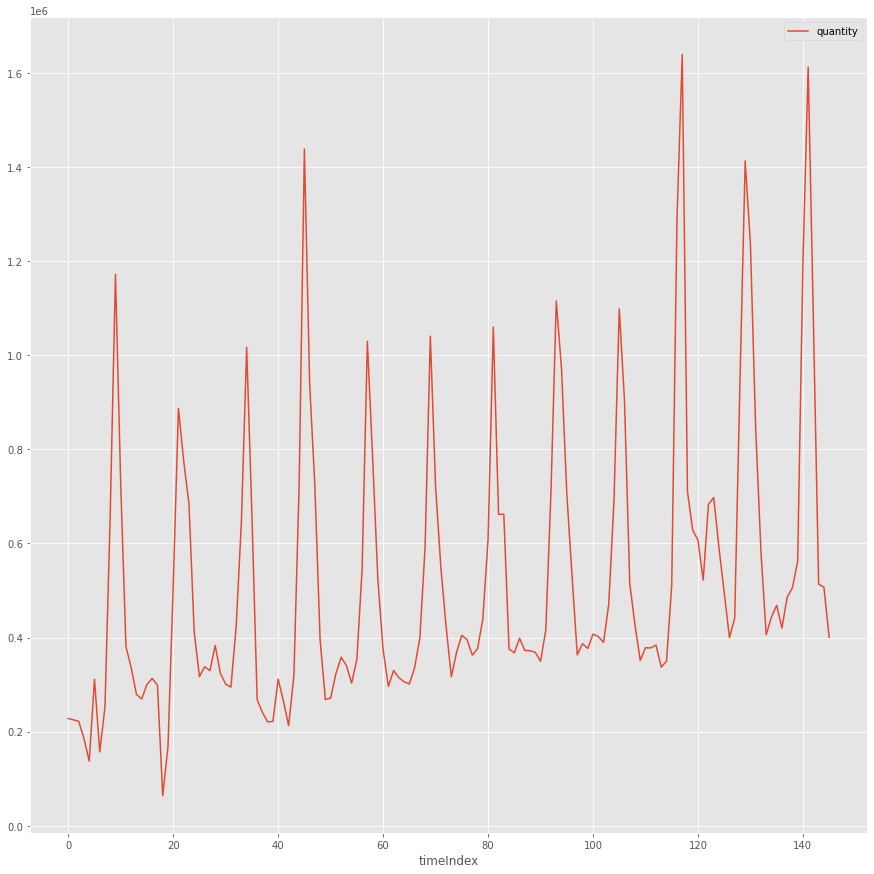

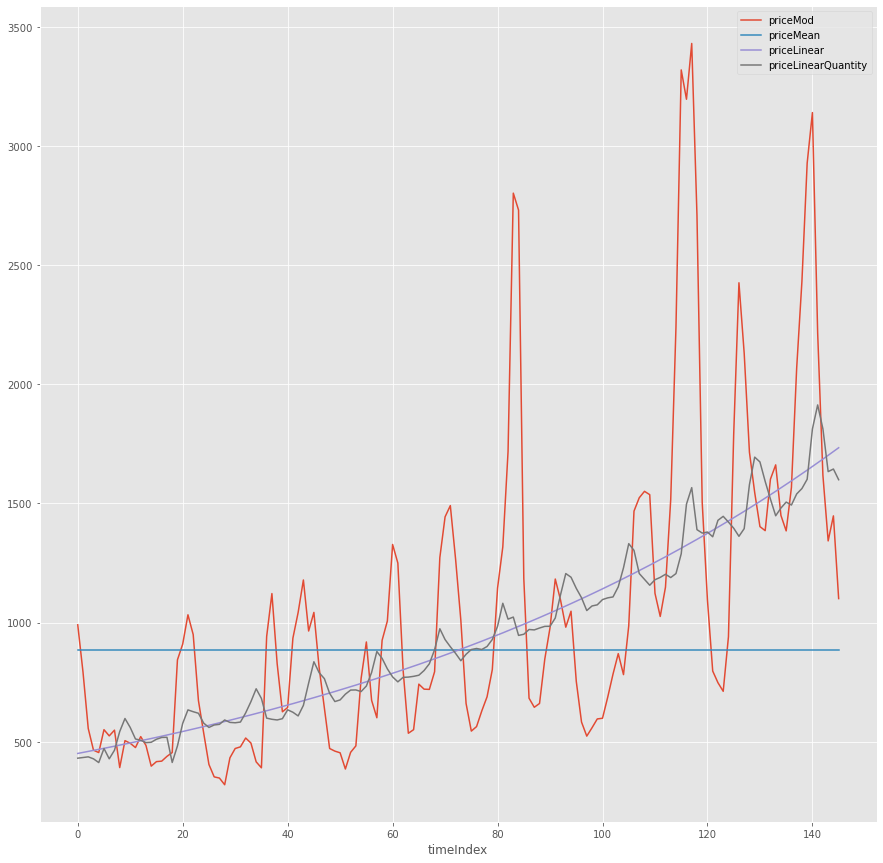

In [58]:
dfBang.plot(kind = "line", x="timeIndex", y = "quantity")
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", 
                                             "priceLinear", "priceLinearQuantity"])

## 2 Выделение тренда и сезонности

При работе с временными рядами выделяют два действия:
- Дифференцирование - расчет разницы с определенным временным лагом
- Декомпозиция - моделирование как тренда, так и сезонности и удаление их из модели.

Предположим, что у вас имеются ежемесячные данные о пассажиропотоке на международных авиалиниях.  
Объем пассажиропотока имеет во времени возрастающий линейный тренд, и в ряде имеется ежегодно повторяющаяся закономерность - сезонность (большинство перевозок приходится на летние месяцы, кроме того, имеется пик меньшей высоты в районе декабрьских каникул). 
Цель декомпозиции как раз и состоит в том, чтобы отделить эти компоненты, то есть разложить ряд на составляющую тренда, сезонную компоненту и оставшуюся нерегулярную составляющую. 

То есть каждый уровень временного ряда формируется под воздействием большого числа факторов, которые условно можно подразделить на три группы:
- факторы, формирующие тенденцию ряда
- факторы, формирующие циклические колебания ряда
- случайные факторы  

Рассмотрим воздействие каждого фактора на временной ряд в отдельности.  
Большинство временных рядов экономических показателей имеют тенденцию, 
характеризующую совокупное долговременное воздействие множества факторов на динамику изучаемого показателя.  
Все эти факторы, взятые в отдельности, могут оказывать разнонаправленное воздействие на исследуемый показатель. Однако в совокупности они формируют его возрастающую или убывающую тенденцию

В большинстве случаев фактический уровень временного ряда можно представить как сумму или произведение трендовой, циклической и случайной компонент. Модель, в которой временной ряд представлен как сумма перечисленных компонент, называется **аддитивной** моделью временного ряда. Модель, в которой временной ряд представлен как произведение перечисленных компонент, называется **мультипликативной** моделью временного ряда. 

**Аддитивная модель** 
$${Y_t} = t (trend) + s (seasonality) + r (residual)$$

![](https://miro.medium.com/max/1360/0*JWWglnH4RBR-SbxC.png)

**Мультипликативная модель** 
$${Y_t} = t (trend) * s (seasonality) * r (residual)$$

![](https://anomaly.io/wp-content/uploads/2015/12/multiplicative-model.png)

Как видим, отличие мультипликативной модели от аддитивной состоит в том, 
что в мультипликативной модели сезонная и случайная составляющие определены в виде относительных величин (коэффициентов), 
а в аддитивной модели – в виде абсолютных величин.   
Эти модели в практических расчетах дадут близкие результаты, если амплитуда колебаний уровней ряда слабо изменяется во времени

Какие примеры аддитивных и мультипликаативных рядов из жизни вы знаете?

### Расчет лагов
Представим временной ряд в виде последовательности разницы между значениями.  
Рассчитаем лаги, выведем их на графике

In [59]:
# Рассчитаем лаги
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()

<AxesSubplot:xlabel='priceModLogShift1', ylabel='priceModLog'>

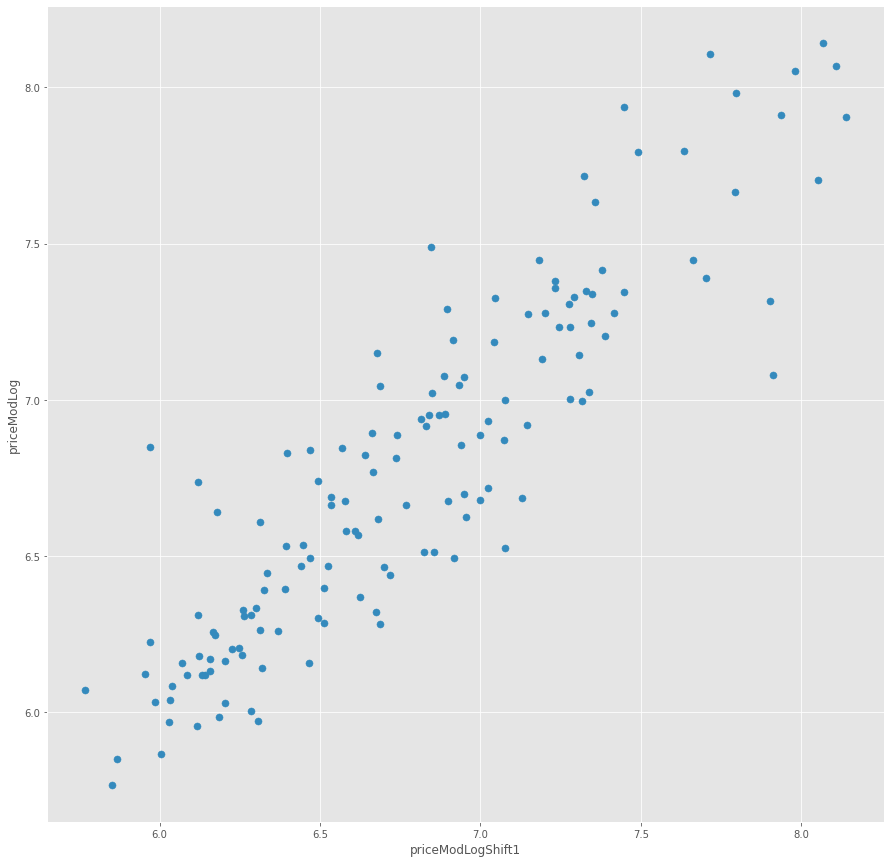

In [60]:
# Выведем на графике priceModLog и priceModLogShift1
dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50)

In [61]:
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1

<AxesSubplot:xlabel='date'>

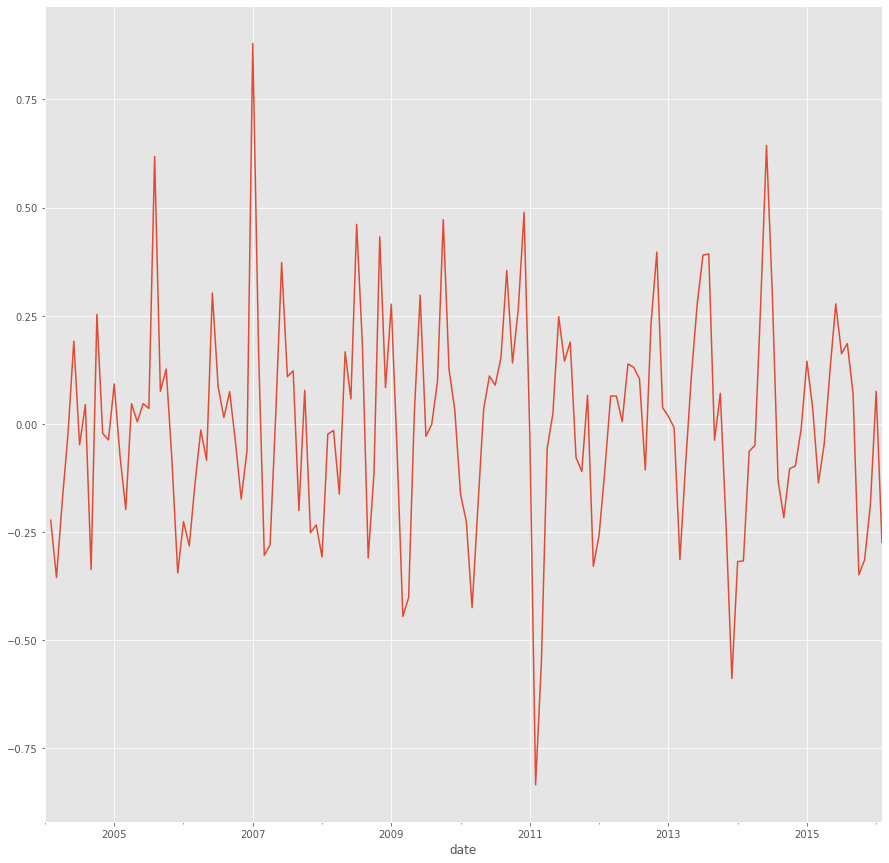

In [62]:
dfBang.priceModLogDiff.plot()

### Декомпозиция 
Декомпозируем наш временной ряд на тренд и сезонность

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [64]:
dfBang.index = dfBang.index.to_timestamp()

In [65]:
dfBang.head()

,quantity,priceMod,date,priceModLog,priceMean,timeIndex,priceLinear,priceLinearQuantity,priceModLogShift1,priceModLogDiff
date,,,,,,,,,,
2004-01-01,227832,991,2004-01-01,6.90,884.57,0,451.29,431.41,nan,nan
2004-02-01,225133,793,2004-02-01,6.68,884.57,1,455.50,434.28,6.90,-0.22
2004-03-01,221952,556,2004-03-01,6.32,884.57,2,459.75,437.01,6.68,-0.36
2004-04-01,185150,465,2004-04-01,6.14,884.57,3,464.03,428.67,6.32,-0.18
2004-05-01,137390,455,2004-05-01,6.12,884.57,4,468.36,413.03,6.14,-0.02


In [66]:
decomposition = seasonal_decompose(dfBang.priceModLog, model = "additive")

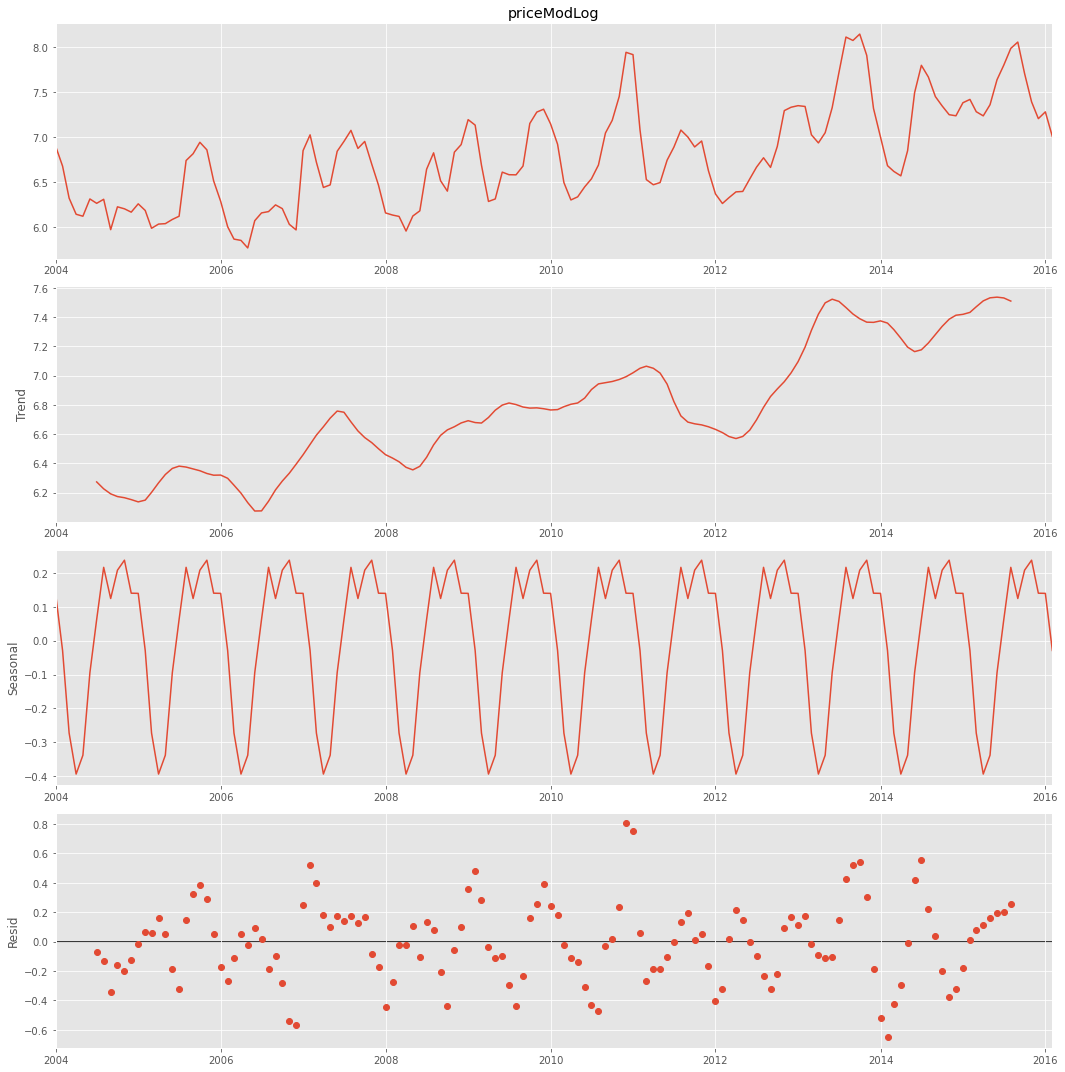

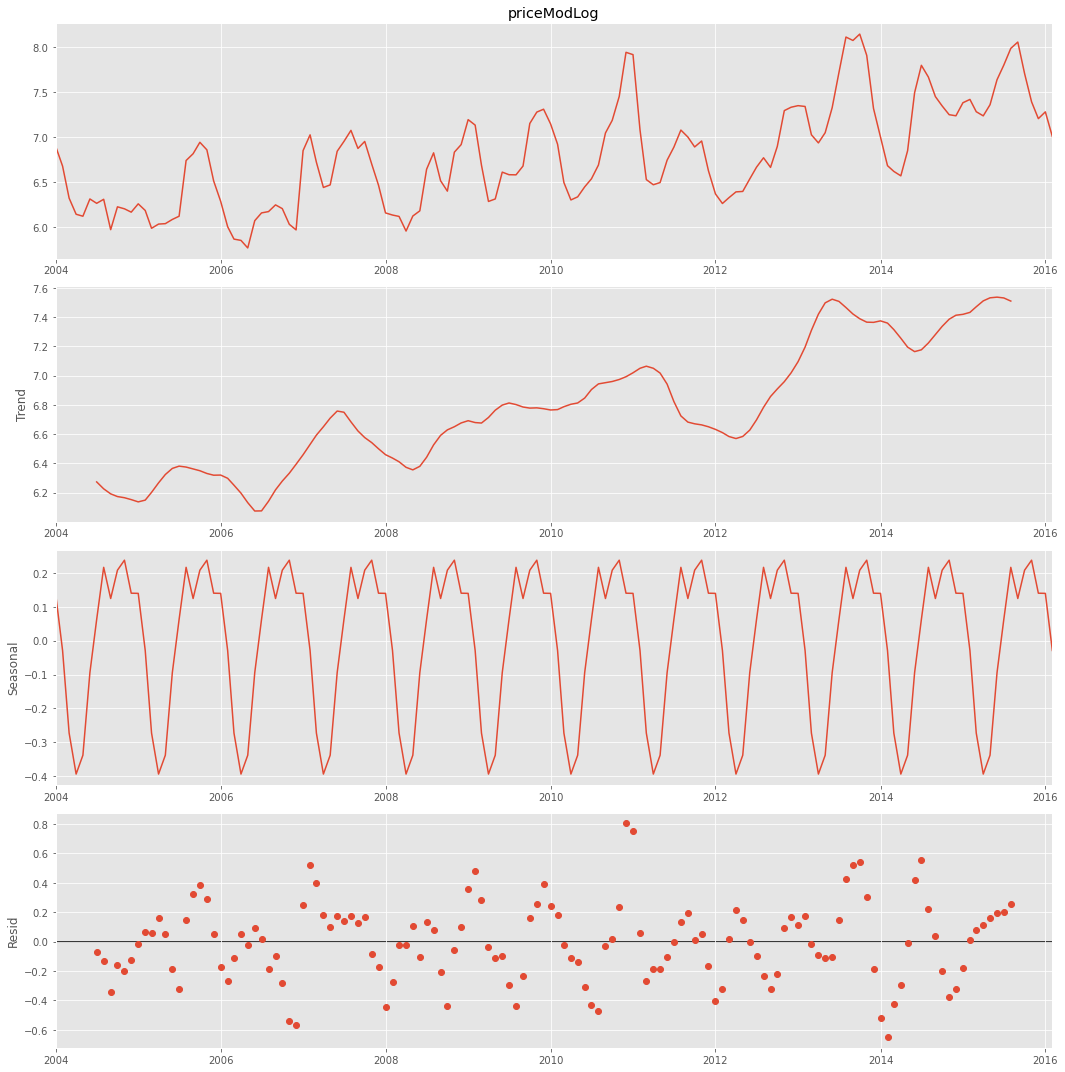

In [67]:
decomposition.plot()

In [68]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [69]:
# Построим ряд по тренду и сезонности
dfBang["priceDecomp"] = np.exp(trend + seasonal)

In [70]:
# Расчет RMSE
model_Decomp_RMSE = RMSE(dfBang.priceDecomp, dfBang.priceMod)
model_Decomp_RMSE

374.10858464802345

<AxesSubplot:xlabel='timeIndex'>

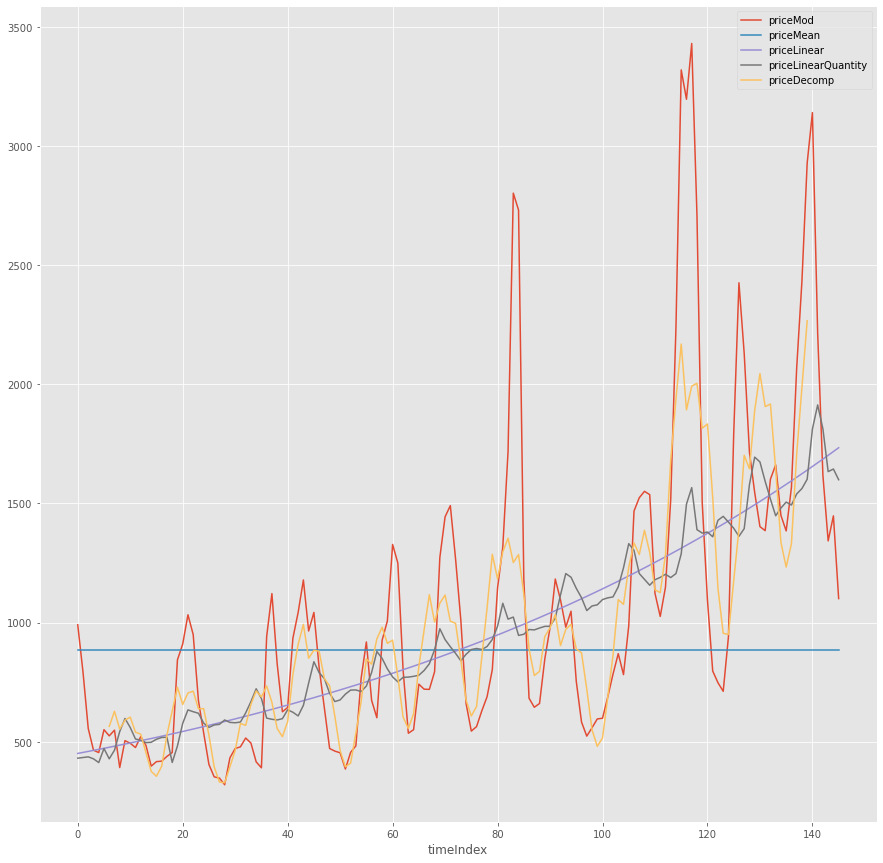

In [71]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceLinearQuantity", "priceDecomp"])

In [72]:
dfBangResults

,Model,Forecast,RMSE
0,Mean,884.57,683.95
1,Linear,Linear,518.52


In [73]:
dfBangResults.loc[3,"Model"] = "priceDecomp"
dfBangResults.loc[3,"Forecast"] = 'priceDecomp'
dfBangResults.loc[3,"RMSE"] = model_Decomp_RMSE
dfBangResults.head()

,Model,Forecast,RMSE
0,Mean,884.57,683.95
1,Linear,Linear,518.52
3,priceDecomp,priceDecomp,374.11


## 3 Стационарность ряда

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как стационарность.  
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках:

![](https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png)  
Временной ряд справа не является стационарным, так как его матожидание со временем растёт

![](https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png)  
Здесь не повезло с дисперсией — разброс значений ряда существенно варьируется в зависимости от периода

![](https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png)  
На последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций


Почему стационарность так важна?  
По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

In [74]:
test = sm.tsa.adfuller(dfBang.priceMod)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -4.004401077671534
p-value:  0.00138764044231547
Critical values:  {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}
Единичных корней нет, ряд стационарен


## 4 Построение модели АRIMA

Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.  
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:  
- p — порядок компоненты AR
- d — порядок интегрированного ряда (порядок разности временного ряда)
- q — порядок компонетны MA  


Параметр d равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную (ACF) и частично автокорреляционную (PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.  

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: acf и pacf.  
Можем построить графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

In [75]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [76]:
# ACF и PACF 
from statsmodels.tsa.stattools import acf, pacf

In [77]:
lag_acf = acf(ts_diff, nlags=20)

/Users/dchesakov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [78]:
lag_acf

array([ 1.        ,  0.40215445, -0.02855346, -0.21472715, -0.23756032,
       -0.26332645, -0.22038359, -0.08576989, -0.0754398 ,  0.01497797,
        0.12361818,  0.20862956,  0.158123  ,  0.02053933, -0.01290934,
       -0.07097602, -0.17993659, -0.09514604, -0.04878255, -0.08854117,
       -0.18810881])

In [79]:
ACF = pd.Series(lag_acf)

<AxesSubplot:>

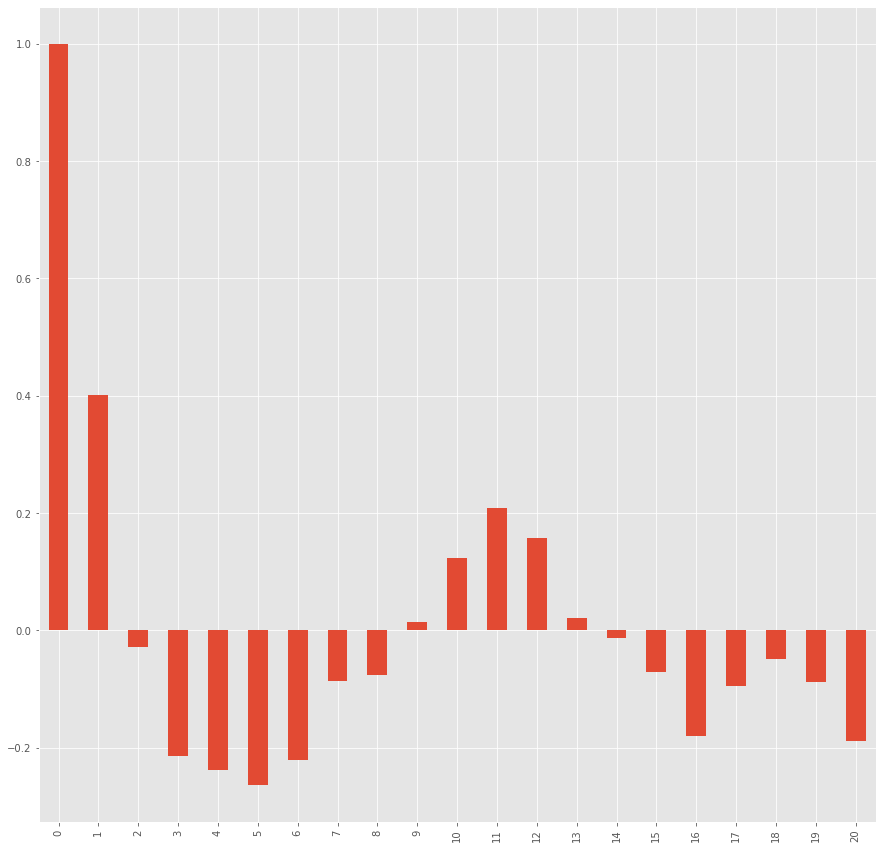

In [81]:
ACF.plot(kind = "bar")

In [82]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [83]:
PACF = pd.Series(lag_pacf)

<AxesSubplot:>

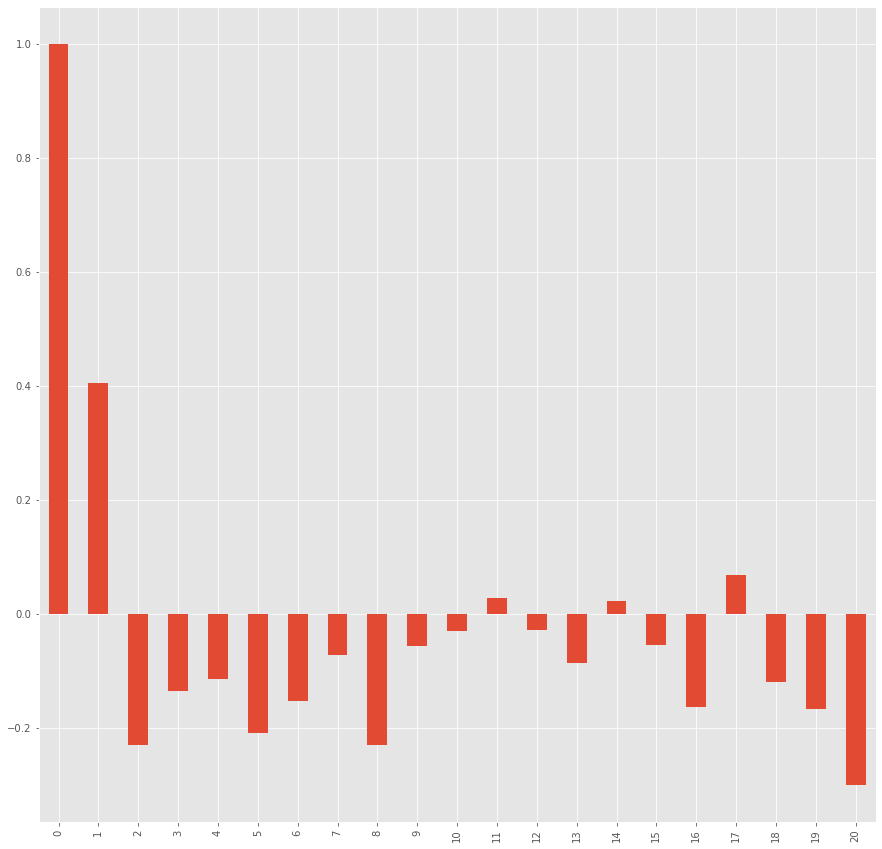

In [84]:
PACF.plot(kind = "bar")

## Построим модель ARIMA 

In [85]:
from statsmodels.tsa.arima_model import ARIMA

In [86]:
ts_diff.head()

date
2004-02-01   -0.22
2004-03-01   -0.36
2004-04-01   -0.18
2004-05-01   -0.02
2004-06-01    0.19
Freq: MS, Name: priceModLogDiff, dtype: float64

In [87]:
# ARIMA Model (1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

/Users/dchesakov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [88]:
results_ARIMA = model_AR1MA.fit(disp = -1)

In [89]:
results_ARIMA.fittedvalues.head()

date
2004-02-01   -0.00
2004-03-01   -0.09
2004-04-01   -0.14
2004-05-01   -0.04
2004-06-01    0.00
Freq: MS, dtype: float64

<AxesSubplot:xlabel='date'>

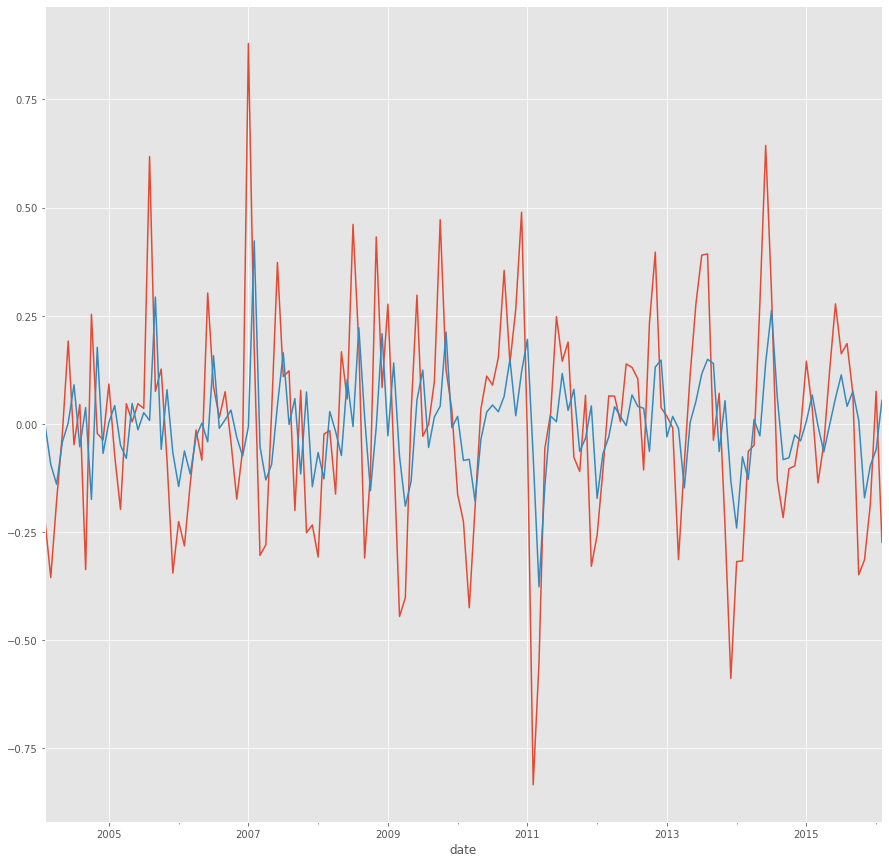

In [90]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot()

In [91]:
ts_diff.sum()

0.1052596023926915

In [92]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

date
2015-10-01    0.01
2015-11-01   -0.17
2015-12-01   -0.10
2016-01-01   -0.06
2016-02-01    0.05
Freq: MS, dtype: float64

In [93]:
predictions_ARIMA_diff.sum()

0.07204869863347368

In [94]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

date
2015-10-01   0.34
2015-11-01   0.17
2015-12-01   0.08
2016-01-01   0.02
2016-02-01   0.07
Freq: MS, dtype: float64

In [99]:
predictions_ARIMA_log = pd.Series(ts[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.tail()

date
2015-10-01   7.24
2015-11-01   7.07
2015-12-01   6.98
2016-01-01   6.92
2016-02-01   6.97
Freq: MS, dtype: float64

In [100]:
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

<AxesSubplot:xlabel='timeIndex'>

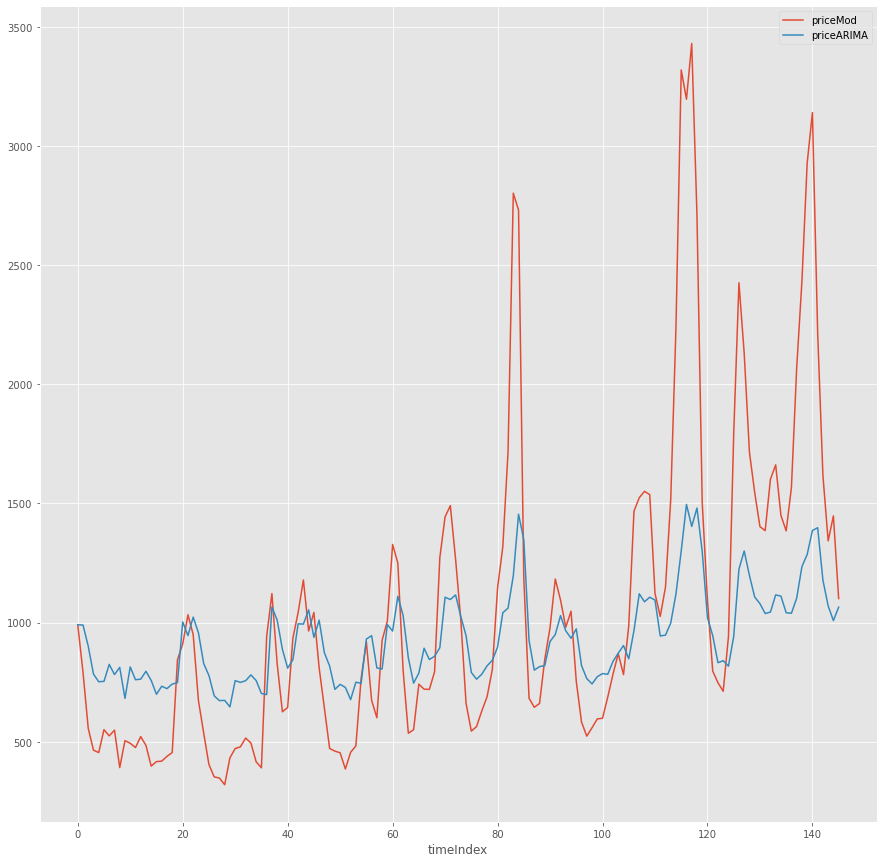

In [101]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceARIMA"])

<AxesSubplot:xlabel='timeIndex'>

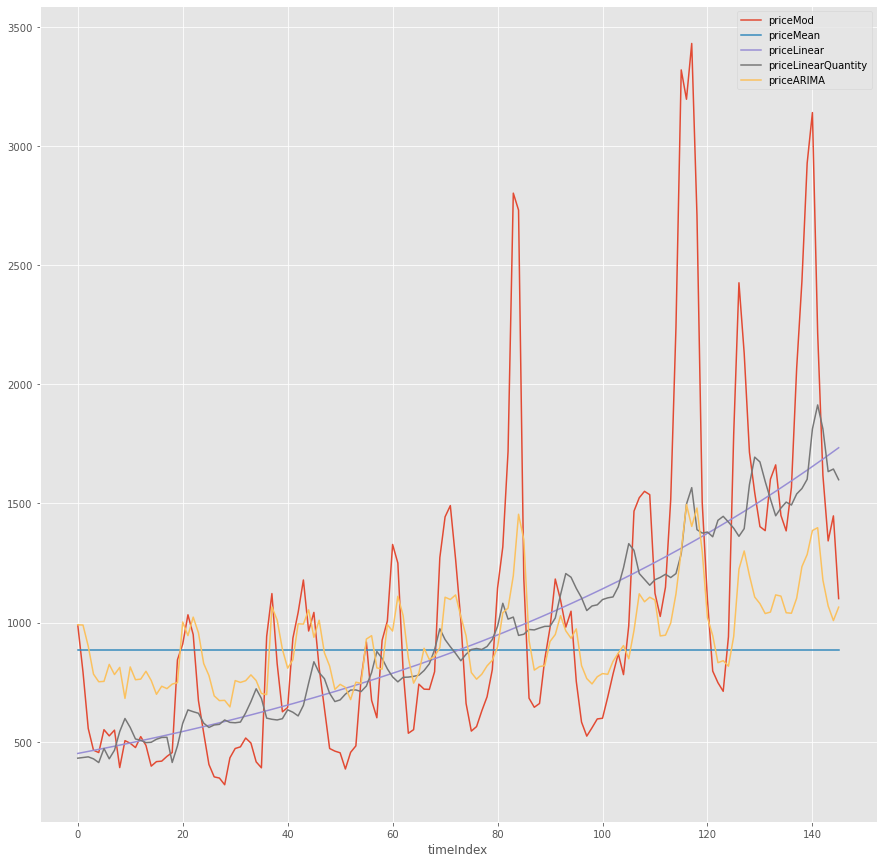

In [102]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", 
                                             "priceLinearQuantity", "priceARIMA"])

In [103]:
# RMSE
model_arima_RMSE = RMSE(dfBang.priceARIMA, dfBang.priceMod)
model_arima_RMSE

517.5438156388656

Обычно подбор параметров для ARIMA — сложный и трудоемкий процесс.  
23-го февраля 2017 года команда Core Data Science из Facebook выпустила новую библиотеку для работы с временными рядами — Prophet. Попробуйте применить новую библиотеку и посмотрите на удобство в использовании и качество предсказания.

### Вывод

На семинаре мы ознакомились с разными подходами к анализу и прогнозированию временных рядов.  
Была рассмотрена интегрированная модель авторегрессии – скользящего среднего (ARIMA), как базовая модель прогнозирования.  
Как вы уже убедились, серебряной пули для решения такого рода задач пока нет.  
Методы, разработанные в 60-е годы прошлого века, (а некоторые и в начале 19-го), по-прежнему пользуются популярностью наравне с неразобранными в рамках данной статьи LSTM или RNN. Отчасти это связано с тем, что задача прогнозирования, как и любая другая задача, возникающая в процессе работы с данными — во многом творческая и уж точно исследовательская. Несмотря на обилие формальных метрик качества и способов оценки параметров, для каждого временного ряда часто приходится подбирать и пробовать что-то своё. Не последнюю роль играет и баланс между качеством и трудозатратами.